In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
PATH = os.path.join(os.getcwd(),'drive/MyDrive')
PATH = os.getcwd()
print(PATH)
# os.chdir(PATH)
print(os.listdir(PATH))
# import MNIST_dataloader

/content/drive/MyDrive
['test_idx.tar', 'LISTA.py', 'data', '.ipynb_checkpoints', 'MNIST_dataloader.py', '__pycache__', 'MNIST', 'Week1_ex2.ipynb']


In [12]:
# libraries

import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# local imports
import MNIST_dataloader
from scipy import linalg
import os
import bokeh
# from ISTA import ISTAI_main
# PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
# print('Folders in the Fast_MRI_Knee:',os.listdir(PATH)) # os.listdir(PATH)
# Batch size
batch_size = 64
# Load train and test
train_loader, test_loader = MNIST_dataloader.create_dataloaders(PATH, batch_size)

if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Load data
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]
def Make_norm(t):
    mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
    return (t-mean)/std

# Week1 
## Exercise 2
## Learned ISTA (LISTA)

In this section, we need to evlove the ISTA into a set of neural netowrk layers. Before to do so, recap of ISTA for sparse decoding problem is following:

$$
\begin{equation}
    x^{k+1}=\mathacal{T}_\lambda(x^k-\mu A^T(Ax^k-y))
\end{equation}
$$

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from matplotlib.image import imread
import numpy as np
from scipy import linalg
import torch

import torch.nn as nn
import torch.nn.functional as F
import Fast_MRI_dataloader 
batch_size = 64

class Fast_MRI(Dataset):
    # initialization of the dataset
    def __init__(self, split,data_loc):
        # save the input parameters
        self.split    = split 
        self.data_loc = data_loc
        
        # get all the files
        self.file_names = glob.glob(f"{data_loc}//{split}//*.npz")
    
    # return the number of examples in this dataset
    def __len__(self):
        return len(self.file_names)*5
    
    # create a a method that retrieves a single item form the dataset
    def __getitem__(self, idx):
        file_name = self.file_names[idx//5]
        data = np.load(file_name)
        
        kspace = data['kspace']
        M = data['M']
        gt = data['gt']
        
        # get one of 3 slices
        kspace = kspace[idx%5,:,:]
        gt = gt[idx%5,:,:]
        
        return kspace, M, gt

# PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
# print(PATH)

# train_loader, test_loader = Fast_MRI_dataloader.create_dataloaders(PATH, batch_size)



## LISTA Function


$$
\begin{equation*}
    x^{k+1} = \Tau_\lambda(W_1y+W_2x^k)
\end{equation*}
$$

$$
\begin{equation}
    \Tau_\lambda((I-\mu A^TA)x+\mu Ay)
\end{equation}
$$

In [42]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
class smoother(nn.Module):
    def __init__(self):
        # ,mu,shrinkage,K,y
        super(smoother,self).__init__()
        self.weight = Variable(torch.ones(1),requires_grad=True)
        
    def forward(self,x):
        """smooth forwarder
        return x + 0.5*(torch.sqrt( torch.square(x + self.weight) + 1) - torch.sqrt( torch.square(x + self.weight) + 1) )
        """
        # x = x.to(device)
        # device = "cuda" if torch.cuda.is_available() else "cpu"
        x = x + 0.5*(torch.sqrt( torch.square(x + self.weight) + 1) - torch.sqrt( torch.square(x + self.weight) + 1) )
        return x



class LISTA_(nn.Module):
    def __init__(self,k=3):
        super(LISTA_,self).__init__()
        """ 2 convolutional layers & 1 smoother layer """
        self.x = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1) 
        self.y = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1) 
        self.k = k
        self.smoother = nn.ModuleList(smoother() for i in range(self.k))
        

    def forward(self,y):
        x = torch.zeros_like(y,requires_grad=False)
        y = y
        for i in range(self.k):
            y_ = self.y(y)
            x_ = self.x(x)
            x = self.smoother[i](y_+x_)

        return x


# for batch_idx,(x_clean,x_noisy,_) in enumerate(tqdm(train_loader)):
#     inputs = x_noisy

# print(inputs.shape)


# md = LISTA_(3)

# x = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1) 

# X = md(inputs)
# # sanity check
# print('smoother inputs',md(inputs).shape)




In [45]:
# Optimizer
learning_rate = 1e-2
model = LISTA_()

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)



In [55]:
import sys
from tqdm import tqdm
loss_iter = []
loss_epoch = []
critereon = nn.MSELoss()
no_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"

import torch

device = torch.device("cpu")

for epoch in range(no_epochs):
    total_loss = 0
    sys.stdout.flush()
    for batch_idx,(x_clean,x_noisy,_) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = x_noisy.to(device)
        # inputs = Make_norm(inputs)
        inputs = inputs.to(device)

        model = model.to(device)
        
        outputs = model(inputs)

        loss = critereon(outputs,x_clean)
        loss.backward()
        optimizer.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],MSE loss:{total_loss/len(train_loader)}')
    sys.stdout.flush()

100%|██████████| 938/938 [00:25<00:00, 37.41it/s]

epoch[1/10],MSE loss:0.05709673464298248



100%|██████████| 938/938 [00:25<00:00, 37.43it/s]

epoch[2/10],MSE loss:0.04862646013498306



100%|██████████| 938/938 [00:25<00:00, 37.49it/s]

epoch[3/10],MSE loss:0.048630017787218094



100%|██████████| 938/938 [00:25<00:00, 36.55it/s]


epoch[4/10],MSE loss:0.04864335060119629


100%|██████████| 938/938 [00:25<00:00, 37.36it/s]

epoch[5/10],MSE loss:0.04865865409374237



100%|██████████| 938/938 [00:26<00:00, 35.70it/s]

epoch[6/10],MSE loss:0.04866883158683777



100%|██████████| 938/938 [00:25<00:00, 37.07it/s]

epoch[7/10],MSE loss:0.048678457736968994



100%|██████████| 938/938 [00:24<00:00, 37.87it/s]

epoch[8/10],MSE loss:0.048677943646907806



100%|██████████| 938/938 [00:25<00:00, 37.27it/s]


epoch[9/10],MSE loss:0.04868263006210327


100%|██████████| 938/938 [00:25<00:00, 37.37it/s]

epoch[10/10],MSE loss:0.04866987466812134


In [58]:
from bokeh.plotting import figure,show
from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
loss_epoch
y = np.array(loss_epoch)
x = np.linspace(0,len(loss_epoch),num=len(loss_epoch))
p = figure(title='EX2c part',y_axis_label='LISTA_loss', x_axis_label='Iteration')
p.line(x, y,line_width=2)
# export_png(p, filename="Ex2_c.png")
show(p,notebook_handle=True)
output_notebook()

# image = get_screenshot_as_png(p, height=300, width=300)

In [ ]:

reconses = dict()
reconses[0]=model(x_noisy_example[0,:,:,:])
reconses[0].size().reshap

torch.Size([1, 32, 32])

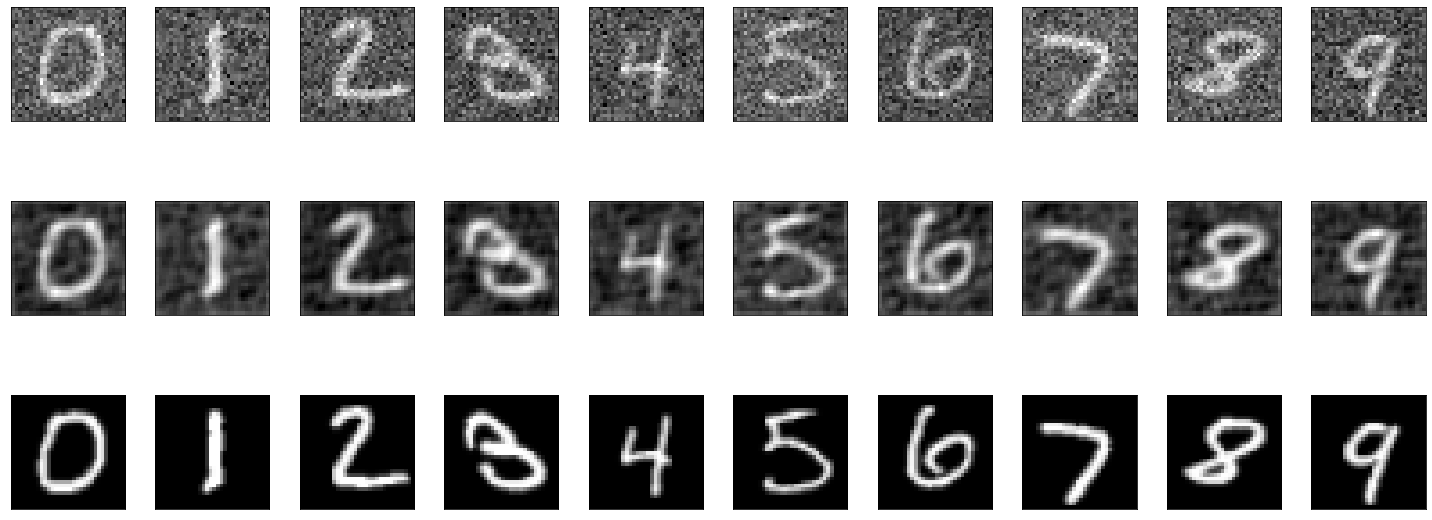

In [59]:

import matplotlib.pyplot as plt

OutPut = dict()
fig = plt.figure(figsize=(20,10))
for i in range(10):
    OutPut[i] = model(x_noisy_example[i,:,:,:])
    plottable_image = OutPut[i].reshape([32,32])
    ax1 = fig.add_subplot(3, 10, i+1)
    ax1.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()

    # plottable_image = outputs[i,0,:,:]
    ax = fig.add_subplot(3, 10, i+11)
    ax.imshow(plottable_image.detach().numpy(),cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
    ax2 = fig.add_subplot(3, 10, i+21)
    ax2.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
Image_path = os.path.join(os.getcwd(),'Image')
# plt.savefig(os.path.join(Image_path,'Ex2_b.png'),dpi=300,bbox_inches='tight')
# plt.savefig('Ex2_b.png',Image_path)